<a href="https://colab.research.google.com/github/anjaliagarwal8/V1_Resnet-NMA/blob/main/V1_resnet_activations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Downloading necessary libraries
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/NMADL_project/
#!git clone https://github.com/dicarlolab/vonenet.git

%cd vonenet/

!python setup.py install

#!git clone https://github.com/bethgelab/foolbox.git
!pip install foolbox
!pip install timm

Mounted at /content/drive
/content/drive/MyDrive/NMADL_project
/content/drive/MyDrive/NMADL_project/vonenet
running install
running bdist_egg
running egg_info
writing vonenet.egg-info/PKG-INFO
writing dependency_links to vonenet.egg-info/dependency_links.txt
writing requirements to vonenet.egg-info/requires.txt
writing top-level names to vonenet.egg-info/top_level.txt
adding license file 'LICENSE'
writing manifest file 'vonenet.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/vonenet
copying build/lib/vonenet/utils.py -> build/bdist.linux-x86_64/egg/vonenet
copying build/lib/vonenet/__init__.py -> build/bdist.linux-x86_64/egg/vonenet
copying build/lib/vonenet/back_ends.py -> build/bdist.linux-x86_64/egg/vonenet
copying build/lib/vonenet/params.py -> build/bdist.linux-x86_64/egg/vonenet
copying build/lib/vonenet/modules.py -> build/bdist.linux-x86

In [2]:
import vonenet
import torchvision
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models
import foolbox as fb
import pandas as pd
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import timm
import cv2
import os

In [3]:

device = torch.device('cuda')

# Pretrained Models

In [4]:
# Load V1 model (Uncomment as desired)

#v1_only_model = vonenet.get_model(model_arch=None, pretrained=False, noise_mode=None).module
#v1_model = vonenet.get_model(model_arch=None, pretrained=False, noise_mode=None, image_size=32, visual_degrees=3, sf_max=5, stride=1, ksize=15).module
v1_resnet50 = vonenet.get_model(model_arch='resnet50_ns', pretrained=True).module
v1_resnet50 = v1_resnet50.eval()
print(v1_resnet50)

Neuronal distributions gabor parameters


/content/drive/My Drive/NMADL_project/vonenet/vonenet/params.py:59: RuntimeWarning: invalid value encountered in true_divide
  ny_dist_marg = n_joint_dist / n_joint_dist.sum(axis=1, keepdims=True)


Model:  VOneResnet50
Sequential(
  (vone_block): VOneBlock(
    (simple_conv_q0): GFB()
    (simple_conv_q1): GFB()
    (simple): ReLU(inplace=True)
    (complex): Identity()
    (gabors): Identity()
    (noise): ReLU(inplace=True)
    (output): Identity()
  )
  (bottleneck): Conv2d(512, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (model): ResNetBackEnd(
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (d

In [5]:
# Resnet50 model without the V1 front-end

resnet50 = models.resnet50(pretrained=True)
resnet50 = resnet50.eval()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

#Foolbox Image Dataset

In [6]:
preprocessing = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3)
bounds = (0, 1)
fmodel = fb.PyTorchModel(resnet50, bounds=bounds, preprocessing=preprocessing)
fmodel = fmodel.transform_bounds((0, 1))
images, labels = fb.utils.samples(fmodel, dataset='imagenet', batchsize=16)

print(images.shape)


torch.Size([16, 3, 224, 224])


Adding adversarial attacks using the Foolbox toolkit

In [7]:

attack = fb.attacks.LinfDeepFoolAttack()
print(attack)

raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.03)
print(is_adv)

LinfDeepFoolAttack(steps=50, candidates=10, overshoot=0.02, loss=logits)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True], device='cuda:0')


In [8]:
epsilons = np.linspace(0.0, 0.005, num=20)

raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=epsilons)

print("is_adv shape:::",is_adv.shape)

#print("is_adv mean:::",is_adv.float32().mean(axis=-1).item())
#robust_accuracy = 1 - is_adv.float32().mean(axis=-1)
#print("robust_accuracy:::",robust_accuracy)


## Run a targeted attack

print("*****************TARGETED ATTACK****************************")
print("Labels:::",labels)

target_classes = (labels + 200) % 1000

print("Target classes:::", target_classes)

criterion = fb.criteria.TargetedMisclassification(target_classes)

attack = fb.attacks.L2CarliniWagnerAttack(steps=100)
# Note: 100 is too little -> results will be bad = perturbations will be relatively large (but 1000 takes much longer)

# epsilons = np.linspace(0.0, 10.0, num=20)
epsilons = None

advs, _, is_adv = attack(fmodel, images, criterion, epsilons=epsilons)

print("is_adv:::",is_adv)

print("distances between images and adv:::",fb.distances.l2(images, advs))

# attack_success_rate = is_adv.float32().mean(axis=-1)

# plt.plot(epsilons, attack_success_rate.numpy())



is_adv shape::: torch.Size([20, 16])
*****************TARGETED ATTACK****************************
Labels::: tensor([243, 559, 438, 990, 949, 853, 609, 609, 915, 455, 541, 630, 741, 471,
        129,  99], device='cuda:0')
Target classes::: tensor([443, 759, 638, 190, 149,  53, 809, 809, 115, 655, 741, 830, 941, 671,
        329, 299], device='cuda:0')
is_adv::: tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True], device='cuda:0')
distances between images and adv::: tensor([0.7682, 0.7037, 0.5149, 1.1855, 0.5832, 0.3686, 0.4669, 0.7730, 0.9449,
        0.9000, 0.6340, 0.3748, 1.9164, 1.4613, 0.5783, 0.8650],
       device='cuda:0')


Visualizing clean and attacked images

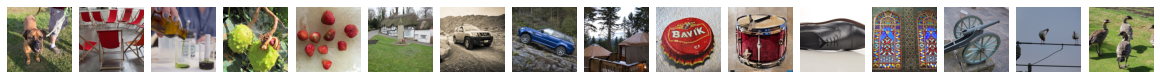

In [9]:
fb.plot.images(images)

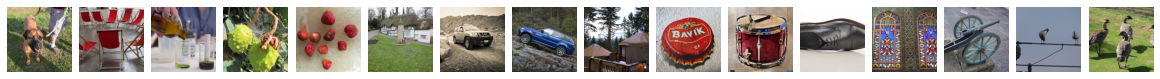

In [10]:
fb.plot.images(advs)

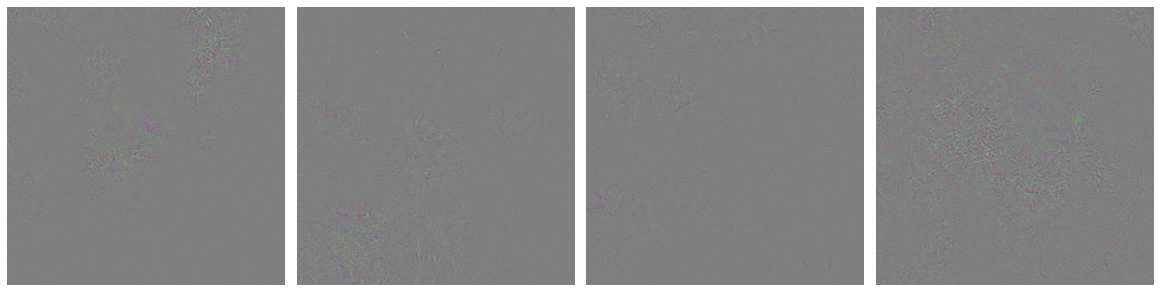

In [11]:
fb.plot.images(advs - images, n=4, bounds=(-0.1, 0.1), scale=4.)

In [12]:
images = images.to('cpu')
advs = advs.to('cpu')

# Activations

In [13]:
def get_act_list(activation):
  act_list  = []

  layer1_0_conv1 = activation['layer1_0_conv1']
  layer1_0_conv2 = activation['layer1_0_conv2']
  layer1_0_conv3 = activation['layer1_0_conv3']
  layer1_0_ds0 = activation['layer1_0_ds0']

  layer1_1_conv1 = activation['layer1_1_conv1']
  layer1_1_conv2 = activation['layer1_1_conv2']
  layer1_1_conv3 = activation['layer1_1_conv3']

  layer1_2_conv1 = activation['layer1_2_conv1']
  layer1_2_conv2 = activation['layer1_2_conv2']
  layer1_2_conv3 = activation['layer1_2_conv3']

  layer2_0_conv1 = activation['layer2_0_conv1']
  layer2_0_conv2 = activation['layer2_0_conv2']
  layer2_0_conv3 = activation['layer2_0_conv3']
  layer2_0_ds0 = activation['layer2_0_ds0']

  layer2_1_conv1 = activation['layer2_1_conv1']
  layer2_1_conv2 = activation['layer2_1_conv2']
  layer2_1_conv3 = activation['layer2_1_conv3']

  layer2_2_conv1 = activation['layer2_2_conv1']
  layer2_2_conv2 = activation['layer2_2_conv2']
  layer2_2_conv3 = activation['layer2_2_conv3']

  layer2_3_conv1 = activation['layer2_3_conv1']
  layer2_3_conv2 = activation['layer2_3_conv2']
  layer2_3_conv3 = activation['layer2_3_conv3']

  layer3_0_conv1 = activation['layer3_0_conv1']
  layer3_0_conv2 = activation['layer3_0_conv2']
  layer3_0_conv3 = activation['layer3_0_conv3']
  layer3_0_ds0 = activation['layer3_0_ds0']

  layer3_1_conv1 = activation['layer3_1_conv1']
  layer3_1_conv2 = activation['layer3_1_conv2']
  layer3_1_conv3 = activation['layer3_1_conv3']

  layer3_2_conv1 = activation['layer3_2_conv1']
  layer3_2_conv2 = activation['layer3_2_conv2']
  layer3_2_conv3 = activation['layer3_2_conv3']

  layer3_3_conv1 = activation['layer3_3_conv1']
  layer3_3_conv2 = activation['layer3_3_conv2']
  layer3_3_conv3 = activation['layer3_3_conv3']

  layer3_4_conv1 = activation['layer3_4_conv1']
  layer3_4_conv2 = activation['layer3_4_conv2']
  layer3_4_conv3 = activation['layer3_4_conv3']

  layer3_5_conv1 = activation['layer3_5_conv1']
  layer3_5_conv2 = activation['layer3_5_conv2']
  layer3_5_conv3 = activation['layer3_5_conv3']

  layer4_0_conv1 = activation['layer4_0_conv1']
  layer4_0_conv2 = activation['layer4_0_conv2']
  layer4_0_conv3 = activation['layer4_0_conv3']
  layer4_0_ds0 = activation['layer4_0_ds0']

  layer4_1_conv1 = activation['layer4_1_conv1']
  layer4_1_conv2 = activation['layer4_1_conv2']
  layer4_1_conv3 = activation['layer4_1_conv3']

  layer4_2_conv1 = activation['layer4_2_conv1']
  layer4_2_conv2 = activation['layer4_2_conv2']
  layer4_2_conv3 = activation['layer4_2_conv3']

  act_list.extend((layer1_0_conv1,layer1_0_conv2,layer1_0_conv3,layer1_0_ds0))
  act_list.extend((layer1_1_conv1,layer1_1_conv2,layer1_1_conv3))
  act_list.extend((layer1_2_conv1,layer1_2_conv2,layer1_2_conv3))

  act_list.extend((layer2_0_conv1,layer1_0_conv2,layer2_0_conv3,layer2_0_ds0))
  act_list.extend((layer2_1_conv1,layer1_1_conv2,layer2_1_conv3))
  act_list.extend((layer2_2_conv1,layer1_2_conv2,layer2_2_conv3))
  act_list.extend((layer2_3_conv1,layer1_2_conv2,layer2_3_conv3))

  act_list.extend((layer3_0_conv1,layer1_0_conv2,layer3_0_conv3,layer3_0_ds0))
  act_list.extend((layer3_1_conv1,layer1_1_conv2,layer3_1_conv3))
  act_list.extend((layer3_2_conv1,layer1_2_conv2,layer3_2_conv3))
  act_list.extend((layer3_3_conv1,layer1_2_conv2,layer3_3_conv3))
  act_list.extend((layer3_4_conv1,layer1_2_conv2,layer3_4_conv3))
  act_list.extend((layer3_5_conv1,layer1_2_conv2,layer3_5_conv3))

  act_list.extend((layer4_0_conv1,layer1_0_conv2,layer4_0_conv3,layer4_0_ds0))
  act_list.extend((layer4_1_conv1,layer1_1_conv2,layer4_1_conv3))
  act_list.extend((layer4_2_conv1,layer1_2_conv2,layer4_2_conv3))

  return act_list

### V1 Resnet50

Clean Activations

In [14]:
v1_resnet50 = vonenet.get_model(model_arch='resnet50_ns', pretrained=True).module
v1_resnet50 = v1_resnet50.eval()
v1_activation = {}
def get_activation(name):
    def hook(model, input, output):
        v1_activation[name] = output.detach()
    return hook

Neuronal distributions gabor parameters


/content/drive/My Drive/NMADL_project/vonenet/vonenet/params.py:59: RuntimeWarning: invalid value encountered in true_divide
  ny_dist_marg = n_joint_dist / n_joint_dist.sum(axis=1, keepdims=True)


Model:  VOneResnet50


In [15]:
# Layer 1 (0)
v1_resnet50.model.layer1[0].conv1.register_forward_hook(get_activation('layer1_0_conv1'))
v1_resnet50.model.layer1[0].conv2.register_forward_hook(get_activation('layer1_0_conv2'))
v1_resnet50.model.layer1[0].conv3.register_forward_hook(get_activation('layer1_0_conv3'))
v1_resnet50.model.layer1[0].downsample[0].register_forward_hook(get_activation('layer1_0_ds0'))

# Layer 1 (1)
v1_resnet50.model.layer1[1].conv1.register_forward_hook(get_activation('layer1_1_conv1'))
v1_resnet50.model.layer1[1].conv2.register_forward_hook(get_activation('layer1_1_conv2'))
v1_resnet50.model.layer1[1].conv3.register_forward_hook(get_activation('layer1_1_conv3'))

# Layer 1 (2)
v1_resnet50.model.layer1[2].conv1.register_forward_hook(get_activation('layer1_2_conv1'))
v1_resnet50.model.layer1[2].conv2.register_forward_hook(get_activation('layer1_2_conv2'))
v1_resnet50.model.layer1[2].conv3.register_forward_hook(get_activation('layer1_2_conv3'))


In [16]:
# Layer 2 (0)
v1_resnet50.model.layer2[0].conv1.register_forward_hook(get_activation('layer2_0_conv1'))
v1_resnet50.model.layer2[0].conv2.register_forward_hook(get_activation('layer2_0_conv2'))
v1_resnet50.model.layer2[0].conv3.register_forward_hook(get_activation('layer2_0_conv3'))
v1_resnet50.model.layer2[0].downsample[0].register_forward_hook(get_activation('layer2_0_ds0'))

# Layer 2 (1)
v1_resnet50.model.layer2[1].conv1.register_forward_hook(get_activation('layer2_1_conv1'))
v1_resnet50.model.layer2[1].conv2.register_forward_hook(get_activation('layer2_1_conv2'))
v1_resnet50.model.layer2[1].conv3.register_forward_hook(get_activation('layer2_1_conv3'))

# Layer 2 (2)
v1_resnet50.model.layer2[2].conv1.register_forward_hook(get_activation('layer2_2_conv1'))
v1_resnet50.model.layer2[2].conv2.register_forward_hook(get_activation('layer2_2_conv2'))
v1_resnet50.model.layer2[2].conv3.register_forward_hook(get_activation('layer2_2_conv3'))

# Layer 2 (3)
v1_resnet50.model.layer2[3].conv1.register_forward_hook(get_activation('layer2_3_conv1'))
v1_resnet50.model.layer2[3].conv2.register_forward_hook(get_activation('layer2_3_conv2'))
v1_resnet50.model.layer2[3].conv3.register_forward_hook(get_activation('layer2_3_conv3'))

In [17]:
# Layer 3 (0)
v1_resnet50.model.layer3[0].conv1.register_forward_hook(get_activation('layer3_0_conv1'))
v1_resnet50.model.layer3[0].conv2.register_forward_hook(get_activation('layer3_0_conv2'))
v1_resnet50.model.layer3[0].conv3.register_forward_hook(get_activation('layer3_0_conv3'))
v1_resnet50.model.layer3[0].downsample[0].register_forward_hook(get_activation('layer3_0_ds0'))

# Layer 3 (1)
v1_resnet50.model.layer3[1].conv1.register_forward_hook(get_activation('layer3_1_conv1'))
v1_resnet50.model.layer3[1].conv2.register_forward_hook(get_activation('layer3_1_conv2'))
v1_resnet50.model.layer3[1].conv3.register_forward_hook(get_activation('layer3_1_conv3'))

# Layer 3 (2)
v1_resnet50.model.layer3[2].conv1.register_forward_hook(get_activation('layer3_2_conv1'))
v1_resnet50.model.layer3[2].conv2.register_forward_hook(get_activation('layer3_2_conv2'))
v1_resnet50.model.layer3[2].conv3.register_forward_hook(get_activation('layer3_2_conv3'))

# Layer 3 (3)
v1_resnet50.model.layer3[3].conv1.register_forward_hook(get_activation('layer3_3_conv1'))
v1_resnet50.model.layer3[3].conv2.register_forward_hook(get_activation('layer3_3_conv2'))
v1_resnet50.model.layer3[3].conv3.register_forward_hook(get_activation('layer3_3_conv3'))

# Layer 3 (4)
v1_resnet50.model.layer3[4].conv1.register_forward_hook(get_activation('layer3_4_conv1'))
v1_resnet50.model.layer3[4].conv2.register_forward_hook(get_activation('layer3_4_conv2'))
v1_resnet50.model.layer3[4].conv3.register_forward_hook(get_activation('layer3_4_conv3'))

# Layer 3 (5)
v1_resnet50.model.layer3[5].conv1.register_forward_hook(get_activation('layer3_5_conv1'))
v1_resnet50.model.layer3[5].conv2.register_forward_hook(get_activation('layer3_5_conv2'))
v1_resnet50.model.layer3[5].conv3.register_forward_hook(get_activation('layer3_5_conv3'))

In [18]:
# Layer 4 (0)
v1_resnet50.model.layer4[0].conv1.register_forward_hook(get_activation('layer4_0_conv1'))
v1_resnet50.model.layer4[0].conv2.register_forward_hook(get_activation('layer4_0_conv2'))
v1_resnet50.model.layer4[0].conv3.register_forward_hook(get_activation('layer4_0_conv3'))
v1_resnet50.model.layer4[0].downsample[0].register_forward_hook(get_activation('layer4_0_ds0'))

# Layer 4 (1)
v1_resnet50.model.layer4[1].conv1.register_forward_hook(get_activation('layer4_1_conv1'))
v1_resnet50.model.layer4[1].conv2.register_forward_hook(get_activation('layer4_1_conv2'))
v1_resnet50.model.layer4[1].conv3.register_forward_hook(get_activation('layer4_1_conv3'))

# Layer 4 (2)
v1_resnet50.model.layer4[2].conv1.register_forward_hook(get_activation('layer4_2_conv1'))
v1_resnet50.model.layer4[2].conv2.register_forward_hook(get_activation('layer4_2_conv2'))
v1_resnet50.model.layer4[2].conv3.register_forward_hook(get_activation('layer4_2_conv3'))

In [19]:
v1_act_clean = []
output = v1_resnet50(images)

v1_act_clean = get_act_list(v1_activation)

In [20]:
for i in range(0,len(v1_act_clean)):
  print(v1_act_clean[i].shape)


torch.Size([16, 64, 56, 56])
torch.Size([16, 64, 56, 56])
torch.Size([16, 256, 56, 56])
torch.Size([16, 256, 56, 56])
torch.Size([16, 64, 56, 56])
torch.Size([16, 64, 56, 56])
torch.Size([16, 256, 56, 56])
torch.Size([16, 64, 56, 56])
torch.Size([16, 64, 56, 56])
torch.Size([16, 256, 56, 56])
torch.Size([16, 128, 56, 56])
torch.Size([16, 64, 56, 56])
torch.Size([16, 512, 28, 28])
torch.Size([16, 512, 28, 28])
torch.Size([16, 128, 28, 28])
torch.Size([16, 64, 56, 56])
torch.Size([16, 512, 28, 28])
torch.Size([16, 128, 28, 28])
torch.Size([16, 64, 56, 56])
torch.Size([16, 512, 28, 28])
torch.Size([16, 128, 28, 28])
torch.Size([16, 64, 56, 56])
torch.Size([16, 512, 28, 28])
torch.Size([16, 256, 28, 28])
torch.Size([16, 64, 56, 56])
torch.Size([16, 1024, 14, 14])
torch.Size([16, 1024, 14, 14])
torch.Size([16, 256, 14, 14])
torch.Size([16, 64, 56, 56])
torch.Size([16, 1024, 14, 14])
torch.Size([16, 256, 14, 14])
torch.Size([16, 64, 56, 56])
torch.Size([16, 1024, 14, 14])
torch.Size([16, 256

In [21]:
# Saving the activations for further analysis
torch.save(v1_act_clean,'v1_resnet50_clean.pt')

Perturbed Activations

In [22]:
v1_resnet50 = vonenet.get_model(model_arch='resnet50_ns', pretrained=True).module
v1_resnet50 = v1_resnet50.eval()
v1_activation = {}
def get_activation(name):
    def hook(model, input, output):
        v1_activation[name] = output.detach()
    return hook

Neuronal distributions gabor parameters


/content/drive/My Drive/NMADL_project/vonenet/vonenet/params.py:59: RuntimeWarning: invalid value encountered in true_divide
  ny_dist_marg = n_joint_dist / n_joint_dist.sum(axis=1, keepdims=True)


Model:  VOneResnet50


In [23]:
# Layer 1 (0)
v1_resnet50.model.layer1[0].conv1.register_forward_hook(get_activation('layer1_0_conv1'))
v1_resnet50.model.layer1[0].conv2.register_forward_hook(get_activation('layer1_0_conv2'))
v1_resnet50.model.layer1[0].conv3.register_forward_hook(get_activation('layer1_0_conv3'))
v1_resnet50.model.layer1[0].downsample[0].register_forward_hook(get_activation('layer1_0_ds0'))

# Layer 1 (1)
v1_resnet50.model.layer1[1].conv1.register_forward_hook(get_activation('layer1_1_conv1'))
v1_resnet50.model.layer1[1].conv2.register_forward_hook(get_activation('layer1_1_conv2'))
v1_resnet50.model.layer1[1].conv3.register_forward_hook(get_activation('layer1_1_conv3'))

# Layer 1 (2)
v1_resnet50.model.layer1[2].conv1.register_forward_hook(get_activation('layer1_2_conv1'))
v1_resnet50.model.layer1[2].conv2.register_forward_hook(get_activation('layer1_2_conv2'))
v1_resnet50.model.layer1[2].conv3.register_forward_hook(get_activation('layer1_2_conv3'))


In [24]:
# Layer 2 (0)
v1_resnet50.model.layer2[0].conv1.register_forward_hook(get_activation('layer2_0_conv1'))
v1_resnet50.model.layer2[0].conv2.register_forward_hook(get_activation('layer2_0_conv2'))
v1_resnet50.model.layer2[0].conv3.register_forward_hook(get_activation('layer2_0_conv3'))
v1_resnet50.model.layer2[0].downsample[0].register_forward_hook(get_activation('layer2_0_ds0'))

# Layer 2 (1)
v1_resnet50.model.layer2[1].conv1.register_forward_hook(get_activation('layer2_1_conv1'))
v1_resnet50.model.layer2[1].conv2.register_forward_hook(get_activation('layer2_1_conv2'))
v1_resnet50.model.layer2[1].conv3.register_forward_hook(get_activation('layer2_1_conv3'))

# Layer 2 (2)
v1_resnet50.model.layer2[2].conv1.register_forward_hook(get_activation('layer2_2_conv1'))
v1_resnet50.model.layer2[2].conv2.register_forward_hook(get_activation('layer2_2_conv2'))
v1_resnet50.model.layer2[2].conv3.register_forward_hook(get_activation('layer2_2_conv3'))

# Layer 2 (3)
v1_resnet50.model.layer2[3].conv1.register_forward_hook(get_activation('layer2_3_conv1'))
v1_resnet50.model.layer2[3].conv2.register_forward_hook(get_activation('layer2_3_conv2'))
v1_resnet50.model.layer2[3].conv3.register_forward_hook(get_activation('layer2_3_conv3'))

In [25]:
# Layer 3 (0)
v1_resnet50.model.layer3[0].conv1.register_forward_hook(get_activation('layer3_0_conv1'))
v1_resnet50.model.layer3[0].conv2.register_forward_hook(get_activation('layer3_0_conv2'))
v1_resnet50.model.layer3[0].conv3.register_forward_hook(get_activation('layer3_0_conv3'))
v1_resnet50.model.layer3[0].downsample[0].register_forward_hook(get_activation('layer3_0_ds0'))

# Layer 3 (1)
v1_resnet50.model.layer3[1].conv1.register_forward_hook(get_activation('layer3_1_conv1'))
v1_resnet50.model.layer3[1].conv2.register_forward_hook(get_activation('layer3_1_conv2'))
v1_resnet50.model.layer3[1].conv3.register_forward_hook(get_activation('layer3_1_conv3'))

# Layer 3 (2)
v1_resnet50.model.layer3[2].conv1.register_forward_hook(get_activation('layer3_2_conv1'))
v1_resnet50.model.layer3[2].conv2.register_forward_hook(get_activation('layer3_2_conv2'))
v1_resnet50.model.layer3[2].conv3.register_forward_hook(get_activation('layer3_2_conv3'))

# Layer 3 (3)
v1_resnet50.model.layer3[3].conv1.register_forward_hook(get_activation('layer3_3_conv1'))
v1_resnet50.model.layer3[3].conv2.register_forward_hook(get_activation('layer3_3_conv2'))
v1_resnet50.model.layer3[3].conv3.register_forward_hook(get_activation('layer3_3_conv3'))

# Layer 3 (4)
v1_resnet50.model.layer3[4].conv1.register_forward_hook(get_activation('layer3_4_conv1'))
v1_resnet50.model.layer3[4].conv2.register_forward_hook(get_activation('layer3_4_conv2'))
v1_resnet50.model.layer3[4].conv3.register_forward_hook(get_activation('layer3_4_conv3'))

# Layer 3 (5)
v1_resnet50.model.layer3[5].conv1.register_forward_hook(get_activation('layer3_5_conv1'))
v1_resnet50.model.layer3[5].conv2.register_forward_hook(get_activation('layer3_5_conv2'))
v1_resnet50.model.layer3[5].conv3.register_forward_hook(get_activation('layer3_5_conv3'))

In [26]:
# Layer 4 (0)
v1_resnet50.model.layer4[0].conv1.register_forward_hook(get_activation('layer4_0_conv1'))
v1_resnet50.model.layer4[0].conv2.register_forward_hook(get_activation('layer4_0_conv2'))
v1_resnet50.model.layer4[0].conv3.register_forward_hook(get_activation('layer4_0_conv3'))
v1_resnet50.model.layer4[0].downsample[0].register_forward_hook(get_activation('layer4_0_ds0'))

# Layer 4 (1)
v1_resnet50.model.layer4[1].conv1.register_forward_hook(get_activation('layer4_1_conv1'))
v1_resnet50.model.layer4[1].conv2.register_forward_hook(get_activation('layer4_1_conv2'))
v1_resnet50.model.layer4[1].conv3.register_forward_hook(get_activation('layer4_1_conv3'))

# Layer 4 (2)
v1_resnet50.model.layer4[2].conv1.register_forward_hook(get_activation('layer4_2_conv1'))
v1_resnet50.model.layer4[2].conv2.register_forward_hook(get_activation('layer4_2_conv2'))
v1_resnet50.model.layer4[2].conv3.register_forward_hook(get_activation('layer4_2_conv3'))

In [27]:
v1_act_pert = []
output = v1_resnet50(advs)

v1_act_pert= get_act_list(v1_activation)

In [28]:
# Saving the activations for further analysis
torch.save(v1_act_pert,'v1_resnet50_pert.pt')

### Resnet50

Clean Activations

In [29]:
resnet50 = models.resnet50(pretrained=True)
resnet50 = resnet50.eval()
res_activation  = {}
def get_activation(name):
    def hook(model, input, output):
        res_activation[name] = output.detach()
    return hook

In [30]:
# Layer 1 (0)
resnet50.layer1[0].conv1.register_forward_hook(get_activation('layer1_0_conv1'))
resnet50.layer1[0].conv2.register_forward_hook(get_activation('layer1_0_conv2'))
resnet50.layer1[0].conv3.register_forward_hook(get_activation('layer1_0_conv3'))
resnet50.layer1[0].downsample[0].register_forward_hook(get_activation('layer1_0_ds0'))

# Layer 1 (1)
resnet50.layer1[1].conv1.register_forward_hook(get_activation('layer1_1_conv1'))
resnet50.layer1[1].conv2.register_forward_hook(get_activation('layer1_1_conv2'))
resnet50.layer1[1].conv3.register_forward_hook(get_activation('layer1_1_conv3'))

# Layer 1 (2)
resnet50.layer1[2].conv1.register_forward_hook(get_activation('layer1_2_conv1'))
resnet50.layer1[2].conv2.register_forward_hook(get_activation('layer1_2_conv2'))
resnet50.layer1[2].conv3.register_forward_hook(get_activation('layer1_2_conv3'))

In [31]:
# Layer 2 (0)
resnet50.layer2[0].conv1.register_forward_hook(get_activation('layer2_0_conv1'))
resnet50.layer2[0].conv2.register_forward_hook(get_activation('layer2_0_conv2'))
resnet50.layer2[0].conv3.register_forward_hook(get_activation('layer2_0_conv3'))
resnet50.layer2[0].downsample[0].register_forward_hook(get_activation('layer2_0_ds0'))

# Layer 2 (1)
resnet50.layer2[1].conv1.register_forward_hook(get_activation('layer2_1_conv1'))
resnet50.layer2[1].conv2.register_forward_hook(get_activation('layer2_1_conv2'))
resnet50.layer2[1].conv3.register_forward_hook(get_activation('layer2_1_conv3'))

# Layer 2 (2)
resnet50.layer2[2].conv1.register_forward_hook(get_activation('layer2_2_conv1'))
resnet50.layer2[2].conv2.register_forward_hook(get_activation('layer2_2_conv2'))
resnet50.layer2[2].conv3.register_forward_hook(get_activation('layer2_2_conv3'))

# Layer 2 (3)
resnet50.layer2[3].conv1.register_forward_hook(get_activation('layer2_3_conv1'))
resnet50.layer2[3].conv2.register_forward_hook(get_activation('layer2_3_conv2'))
resnet50.layer2[3].conv3.register_forward_hook(get_activation('layer2_3_conv3'))

In [32]:
# Layer 3 (0)
resnet50.layer3[0].conv1.register_forward_hook(get_activation('layer3_0_conv1'))
resnet50.layer3[0].conv2.register_forward_hook(get_activation('layer3_0_conv2'))
resnet50.layer3[0].conv3.register_forward_hook(get_activation('layer3_0_conv3'))
resnet50.layer3[0].downsample[0].register_forward_hook(get_activation('layer3_0_ds0'))

# Layer 3 (1)
resnet50.layer3[1].conv1.register_forward_hook(get_activation('layer3_1_conv1'))
resnet50.layer3[1].conv2.register_forward_hook(get_activation('layer3_1_conv2'))
resnet50.layer3[1].conv3.register_forward_hook(get_activation('layer3_1_conv3'))

# Layer 3 (2)
resnet50.layer3[2].conv1.register_forward_hook(get_activation('layer3_2_conv1'))
resnet50.layer3[2].conv2.register_forward_hook(get_activation('layer3_2_conv2'))
resnet50.layer3[2].conv3.register_forward_hook(get_activation('layer3_2_conv3'))

# Layer 3 (3)
resnet50.layer3[3].conv1.register_forward_hook(get_activation('layer3_3_conv1'))
resnet50.layer3[3].conv2.register_forward_hook(get_activation('layer3_3_conv2'))
resnet50.layer3[3].conv3.register_forward_hook(get_activation('layer3_3_conv3'))

# Layer 3 (4)
resnet50.layer3[4].conv1.register_forward_hook(get_activation('layer3_4_conv1'))
resnet50.layer3[4].conv2.register_forward_hook(get_activation('layer3_4_conv2'))
resnet50.layer3[4].conv3.register_forward_hook(get_activation('layer3_4_conv3'))

# Layer 3 (5)
resnet50.layer3[5].conv1.register_forward_hook(get_activation('layer3_5_conv1'))
resnet50.layer3[5].conv2.register_forward_hook(get_activation('layer3_5_conv2'))
resnet50.layer3[5].conv3.register_forward_hook(get_activation('layer3_5_conv3'))

In [33]:
# Layer 4 (0)
resnet50.layer4[0].conv1.register_forward_hook(get_activation('layer4_0_conv1'))
resnet50.layer4[0].conv2.register_forward_hook(get_activation('layer4_0_conv2'))
resnet50.layer4[0].conv3.register_forward_hook(get_activation('layer4_0_conv3'))
resnet50.layer4[0].downsample[0].register_forward_hook(get_activation('layer4_0_ds0'))

# Layer 4 (1)
resnet50.layer4[1].conv1.register_forward_hook(get_activation('layer4_1_conv1'))
resnet50.layer4[1].conv2.register_forward_hook(get_activation('layer4_1_conv2'))
resnet50.layer4[1].conv3.register_forward_hook(get_activation('layer4_1_conv3'))

# Layer 4 (2)
resnet50.layer4[2].conv1.register_forward_hook(get_activation('layer4_2_conv1'))
resnet50.layer4[2].conv2.register_forward_hook(get_activation('layer4_2_conv2'))
resnet50.layer4[2].conv3.register_forward_hook(get_activation('layer4_2_conv3'))

In [34]:
res_act_clean = []
output = resnet50(images)

res_act_clean = get_act_list(res_activation)

In [35]:
# Saving the activations for further analysis
torch.save(res_act_clean,'resnet50_clean.pt')

Perturbed Activations

In [36]:
resnet50 = models.resnet50(pretrained=True)
resnet50 = resnet50.eval()
res_activation  = {}
def get_activation(name):
    def hook(model, input, output):
        res_activation[name] = output.detach()
    return hook

In [37]:
# Layer 1 (0)
resnet50.layer1[0].conv1.register_forward_hook(get_activation('layer1_0_conv1'))
resnet50.layer1[0].conv2.register_forward_hook(get_activation('layer1_0_conv2'))
resnet50.layer1[0].conv3.register_forward_hook(get_activation('layer1_0_conv3'))
resnet50.layer1[0].downsample[0].register_forward_hook(get_activation('layer1_0_ds0'))

# Layer 1 (1)
resnet50.layer1[1].conv1.register_forward_hook(get_activation('layer1_1_conv1'))
resnet50.layer1[1].conv2.register_forward_hook(get_activation('layer1_1_conv2'))
resnet50.layer1[1].conv3.register_forward_hook(get_activation('layer1_1_conv3'))

# Layer 1 (2)
resnet50.layer1[2].conv1.register_forward_hook(get_activation('layer1_2_conv1'))
resnet50.layer1[2].conv2.register_forward_hook(get_activation('layer1_2_conv2'))
resnet50.layer1[2].conv3.register_forward_hook(get_activation('layer1_2_conv3'))

In [38]:
# Layer 2 (0)
resnet50.layer2[0].conv1.register_forward_hook(get_activation('layer2_0_conv1'))
resnet50.layer2[0].conv2.register_forward_hook(get_activation('layer2_0_conv2'))
resnet50.layer2[0].conv3.register_forward_hook(get_activation('layer2_0_conv3'))
resnet50.layer2[0].downsample[0].register_forward_hook(get_activation('layer2_0_ds0'))

# Layer 2 (1)
resnet50.layer2[1].conv1.register_forward_hook(get_activation('layer2_1_conv1'))
resnet50.layer2[1].conv2.register_forward_hook(get_activation('layer2_1_conv2'))
resnet50.layer2[1].conv3.register_forward_hook(get_activation('layer2_1_conv3'))

# Layer 2 (2)
resnet50.layer2[2].conv1.register_forward_hook(get_activation('layer2_2_conv1'))
resnet50.layer2[2].conv2.register_forward_hook(get_activation('layer2_2_conv2'))
resnet50.layer2[2].conv3.register_forward_hook(get_activation('layer2_2_conv3'))

# Layer 2 (3)
resnet50.layer2[3].conv1.register_forward_hook(get_activation('layer2_3_conv1'))
resnet50.layer2[3].conv2.register_forward_hook(get_activation('layer2_3_conv2'))
resnet50.layer2[3].conv3.register_forward_hook(get_activation('layer2_3_conv3'))

In [39]:
# Layer 3 (0)
resnet50.layer3[0].conv1.register_forward_hook(get_activation('layer3_0_conv1'))
resnet50.layer3[0].conv2.register_forward_hook(get_activation('layer3_0_conv2'))
resnet50.layer3[0].conv3.register_forward_hook(get_activation('layer3_0_conv3'))
resnet50.layer3[0].downsample[0].register_forward_hook(get_activation('layer3_0_ds0'))

# Layer 3 (1)
resnet50.layer3[1].conv1.register_forward_hook(get_activation('layer3_1_conv1'))
resnet50.layer3[1].conv2.register_forward_hook(get_activation('layer3_1_conv2'))
resnet50.layer3[1].conv3.register_forward_hook(get_activation('layer3_1_conv3'))

# Layer 3 (2)
resnet50.layer3[2].conv1.register_forward_hook(get_activation('layer3_2_conv1'))
resnet50.layer3[2].conv2.register_forward_hook(get_activation('layer3_2_conv2'))
resnet50.layer3[2].conv3.register_forward_hook(get_activation('layer3_2_conv3'))

# Layer 3 (3)
resnet50.layer3[3].conv1.register_forward_hook(get_activation('layer3_3_conv1'))
resnet50.layer3[3].conv2.register_forward_hook(get_activation('layer3_3_conv2'))
resnet50.layer3[3].conv3.register_forward_hook(get_activation('layer3_3_conv3'))

# Layer 3 (4)
resnet50.layer3[4].conv1.register_forward_hook(get_activation('layer3_4_conv1'))
resnet50.layer3[4].conv2.register_forward_hook(get_activation('layer3_4_conv2'))
resnet50.layer3[4].conv3.register_forward_hook(get_activation('layer3_4_conv3'))

# Layer 3 (5)
resnet50.layer3[5].conv1.register_forward_hook(get_activation('layer3_5_conv1'))
resnet50.layer3[5].conv2.register_forward_hook(get_activation('layer3_5_conv2'))
resnet50.layer3[5].conv3.register_forward_hook(get_activation('layer3_5_conv3'))

In [40]:
# Layer 4 (0)
resnet50.layer4[0].conv1.register_forward_hook(get_activation('layer4_0_conv1'))
resnet50.layer4[0].conv2.register_forward_hook(get_activation('layer4_0_conv2'))
resnet50.layer4[0].conv3.register_forward_hook(get_activation('layer4_0_conv3'))
resnet50.layer4[0].downsample[0].register_forward_hook(get_activation('layer4_0_ds0'))

# Layer 4 (1)
resnet50.layer4[1].conv1.register_forward_hook(get_activation('layer4_1_conv1'))
resnet50.layer4[1].conv2.register_forward_hook(get_activation('layer4_1_conv2'))
resnet50.layer4[1].conv3.register_forward_hook(get_activation('layer4_1_conv3'))

# Layer 4 (2)
resnet50.layer4[2].conv1.register_forward_hook(get_activation('layer4_2_conv1'))
resnet50.layer4[2].conv2.register_forward_hook(get_activation('layer4_2_conv2'))
resnet50.layer4[2].conv3.register_forward_hook(get_activation('layer4_2_conv3'))

In [41]:
res_act_pert = []
output = resnet50(advs)

res_act_pert = get_act_list(res_activation)

In [42]:
# Saving the activations for further analysis
torch.save(res_act_pert,'resnet50_pert.pt')

Done!